# Changes from v13
* Splitting out the data by CPT section and running one model for each one

# Notes

## Questions
* Run the data for each category with only no filter, one, and three CPT codes for each discharge summary
    * ANSWER: It performs better with only 1 CPT per note and 3 had a decrease of 3% in accuracy
* Does including all notes/CPT sections improve accuracy?
    * ANSWER: No, it decreased the accuracy
* Does including some sections improve accuracy when included with discharge summary?
    * No, accuracy went from 80% to 71%- at least for the E/M category
* Does accuracy improve when there are more notes per CPT code?
    * Yes
* What is the lowest threshold I can use without decreasing accuracy?
    * It seems like I don't need a threshold
* Does imbalance correction improve model accuracy?
    * Yes, it makes a huge difference
* Is undersampling or over-sampling a better method for imbalance correction?
    * Oversampling since the lowest records only contain one note - could also try SMOTE and see if that gives better results or not
* Use label encoder for the CPT codes
    * Does the accuracy improve when using labelencoder?
* Is limiting CPT codes to just one excluding CPT codes?
    * No
* Can I use the descriptions in the CPT table to help improve my analysis?
    * Yes, only for 94002 and 94003
* Do a greater variety of CPT scores improve CPT f-scores?
    * No, they slightly change, but probably only b/c what goes in train and test changes
* Does the accuracy improve when filtered to each CPT section individually?
    * Yes



# Next Steps

* Adjust model so it can be run in smaller chunks
* Check the accuracy for those CPT codes in v13 and see if accuracy decreased when looking at individual sections
    * Add option to run the code without stratifying by section
* Complete model to predict CPT and ICD codes with their probabilities
* Serialize the model to be used in streamlit
* Add loading statements with time it module times for how long each section takes to run
* Add HCC code that suggests HCC's based on the output
* Add descriptions for the ICD and CPT code predictions
* Add top most predictive feature names for the model in the output
* Use label encoder and then reverse transform the encoded values

Extra:
* Add K-Means clustering to add suggested codes based on CPT and ICD code output
* Add the model to a class with functions as methods

# Import Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gzip
import pandas as pd
import glob
import string
from sklearn.utils import resample
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import classification_report


# Import the MIMIC data

In [2]:
dataset_dictionary = {}

for file_path in glob.glob('.\\Data\\MIMIC Files\*'):
    file_name = file_path.split('\\')[3].split('.')[0]
    with gzip.open(file_path, mode='r') as file:
        dataset_dictionary[file_name] = pd.read_csv(file)

c:\users\amartins\onedrive - intermountain healthcare\python_pycharm_virt_env\.venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,5,7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\users\amartins\onedrive - intermountain healthcare\python_pycharm_virt_env\.venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Assign Datatypes

In [6]:
# Check all the datasets exist in the dictionary 
print(dataset_dictionary.keys())

# Check the datatypes and information for each table 
for i in dataset_dictionary.keys():
    print(dataset_dictionary[i].info())

# Correct any datatype issues #####

# CPTEVENTS
dataset_dictionary['CPTEVENTS'].loc[:,['SECTIONHEADER','CPT_CD']] = dataset_dictionary['CPTEVENTS'].loc[:,['SECTIONHEADER','CPT_CD']].astype(str)
dataset_dictionary['CPTEVENTS']['CHARTDATE'] = dataset_dictionary['CPTEVENTS']['CHARTDATE'].to_datetime()

dict_keys(['CPTEVENTS', 'DIAGNOSES_ICD', 'D_CPT', 'D_ICD_DIAGNOSES', 'D_ICD_PROCEDURES', 'NOTEEVENTS', 'PATIENTS', 'PROCEDURES_ICD'])
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573146 entries, 0 to 573145
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ROW_ID            573146 non-null  int64  
 1   SUBJECT_ID        573146 non-null  int64  
 2   HADM_ID           573146 non-null  int64  
 3   COSTCENTER        573146 non-null  object 
 4   CHARTDATE         101545 non-null  object 
 5   CPT_CD            573146 non-null  object 
 6   CPT_NUMBER        573128 non-null  float64
 7   CPT_SUFFIX        22 non-null      object 
 8   TICKET_ID_SEQ     471601 non-null  float64
 9   SECTIONHEADER     573146 non-null  object 
 10  SUBSECTIONHEADER  573125 non-null  object 
 11  DESCRIPTION       101545 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 52.5+ MB
None
<class 'pandas.

AttributeError: 'Series' object has no attribute 'to_datetime'

# Exploratory Data Analysis - CPTEVENTS Table


Total CPT counts per section

 SECTIONHEADER
Anesthesia                      687
Emerging technology              22
Evaluation and management    404388
Medicine                     114194
Pathology and laboratory         53
Radiology                      2974
Surgery                       50807
nan                              21
Name: CPT_CD, dtype: int64

Total Unique CPT counts per section

 SECTIONHEADER
Anesthesia                      5
Emerging technology             8
Evaluation and management      58
Medicine                       91
Pathology and laboratory        4
Radiology                      61
Surgery                      1784
nan                             7
Name: CPT_CD, dtype: int64

 Section Header: Anesthesia 

count      5.000000
mean     137.400000
std      243.206291
min        2.000000
25%       21.000000
50%       37.000000
75%       56.000000
max      571.000000
Name: CPT_CD, dtype: float64

 Section Header: Emerging technology 

count    8.00000
mean     2

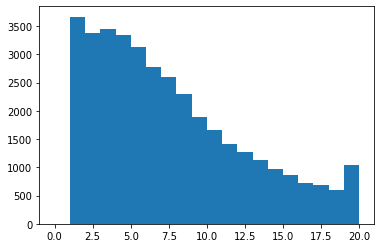

In [79]:
# How many CPT codes are in the data for each CPT section? -----
data_cpt = dataset_dictionary['CPTEVENTS']
print('\nTotal CPT counts per section\n\n', data_cpt.groupby('SECTIONHEADER')['CPT_CD'].count())

# How many unique CPT codes are there per CPT section? -----
data_nodups = data_cpt.loc[:,['CPT_CD', 'SECTIONHEADER']].drop_duplicates()
print('\nTotal Unique CPT counts per section\n\n', data_nodups.groupby('SECTIONHEADER')['CPT_CD'].count())

# What is the distribution of counts for each CPT code per section? -----
for i in np.unique(data_cpt['SECTIONHEADER']):
    print('\n Section Header:',i,'\n')
    print(data_cpt[data_cpt['SECTIONHEADER'] == i].groupby('CPT_CD')['CPT_CD'].count().describe())
    
# How many unique CPT codes are there per CPT section when filtered to the Discharge Summary Section in the Note Events Table? -----
data_notes = dataset_dictionary['NOTEEVENTS']
data_notes = data_notes[data_notes['CATEGORY'] == 'Discharge summary']
data_merged = data_notes.merge(data_cpt, on = ['SUBJECT_ID','HADM_ID'])
data_nodups = data_merged.loc[:,['CPT_CD', 'SECTIONHEADER']].drop_duplicates()
print('\nTotal Unique CPT counts per section\n\n', data_nodups.groupby('SECTIONHEADER')['CPT_CD'].count())

# Are there multiple CPT codes per encounter? -----
# Answer: Yes

data_cpt.groupby('HADM_ID')['CPT_CD'].count()

# What percentage of encounters only have one CPT code?
# Answer: 8.3%
data_grouped = data_cpt.groupby('HADM_ID')['CPT_CD'].count()
(data_grouped == 1).sum()/ len(np.unique(data_cpt['HADM_ID']))

# What does the distribution look like for number of CPT codes per encounter?
data_grouped = data_cpt.groupby('HADM_ID')['CPT_CD'].count()
plt.hist(data_grouped, bins=range(21))
plt.show()

# Exploratory Data Analysis - NOTEEVENTS Table

In [103]:
data = dataset_dictionary['NOTEEVENTS']

# What are the unique categories?
print(np.unique(data['CATEGORY']))

# What do some of the notes look like in each category?
print(data[data['CATEGORY'] == 'Physician ']['TEXT'].iloc[0])

# How many notes are there per category?
data.groupby('CATEGORY')['CATEGORY'].count()


['Case Management ' 'Consult' 'Discharge summary' 'ECG' 'Echo' 'General'
 'Nursing' 'Nursing/other' 'Nutrition' 'Pharmacy' 'Physician ' 'Radiology'
 'Rehab Services' 'Respiratory ' 'Social Work']
Chief Complaint:
   24 Hour Events:
 Continued to be anuric.  Tolerated HD well.  Decision today by pt and
   wife to convert to [**Name (NI) 617**].
   History obtained from Patient
   Allergies:
   History obtained from PatientHeparin Agents
   Thrombocytopeni
   Last dose of Antibiotics:
   Piperacillin - [**2138-3-20**] 08:00 PM
   Piperacillin/Tazobactam (Zosyn) - [**2138-3-21**] 09:00 AM
   Metronidazole - [**2138-3-21**] 10:12 AM
   Infusions:
   Other ICU medications:
   Other medications:
   Changes to medical and family history:
   Review of systems is unchanged from admission except as noted below
   Review of systems:
   Flowsheet Data as of  [**2138-3-21**] 02:56 PM
   Vital signs
   Hemodynamic monitoring
   Fluid balance
                                                          

CATEGORY
Case Management         967
Consult                  98
Discharge summary     59652
ECG                  209051
Echo                  45794
General                8301
Nursing              223556
Nursing/other        822497
Nutrition              9418
Pharmacy                103
Physician            141624
Radiology            522279
Rehab Services         5431
Respiratory           31739
Social Work            2670
Name: CATEGORY, dtype: int64

# Join the tables

In [35]:
def join_tables(dataset_dictionary, category=['Discharge summary'], all_notes=False):

    # Define tables
    note_events_base = dataset_dictionary['NOTEEVENTS']
    cpt_events_base = dataset_dictionary['CPTEVENTS']
    
    # Combine text for each subject and encounter
    if all_notes == False:
        note_events_base = note_events_base[note_events_base.loc[:,'CATEGORY'].isin(category)]
        
    note_events = note_events_base.groupby(['SUBJECT_ID', 'HADM_ID'], as_index=False)['TEXT'].agg(sum)
    
    # Create CPT table
    cpt_events_base = cpt_events_base.loc[:, ['SUBJECT_ID','HADM_ID', 'CPT_CD', 'SECTIONHEADER', 'DESCRIPTION']]
    cpt_events = cpt_events_base.drop_duplicates()
    
    # Join the datasets
    note_cpt = note_events.merge(cpt_events, on = ['SUBJECT_ID','HADM_ID'])
    
    # Replace any nulls with blanks
    x = note_cpt[note_cpt['DESCRIPTION'].isnull()]
    x['DESCRIPTION'] = ''
    y = note_cpt[note_cpt['DESCRIPTION'].notnull()]
    note_cpt = pd.concat([x,y])
    
    # Combine description and text columns
    note_cpt['TEXT'] = note_cpt['TEXT'] + note_cpt['DESCRIPTION']
    note_cpt = note_cpt.drop('DESCRIPTION', axis=1)
    
    return note_cpt
    
note_cpt = join_tables(dataset_dictionary)
# ['Consult','Discharge summary','General', 'Nursing', 'Nursing/other'\
#                                             , 'Physician ','Rehab Services','Respiratory ']

# Drop notes with the nan sectionheader
drop_ls = note_cpt[note_cpt['SECTIONHEADER'] == 'nan']
note_cpt = note_cpt.drop(drop_ls.index)

{'Discharge summary'}


<ipython-input-35-339a9c08c549>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['DESCRIPTION'] = ''


# Join the Tables - Exploratory Analysis

In [37]:
# Check the base table against the new table after joins
note_cpt[note_cpt['HADM_ID'] == 199993]
data = dataset_dictionary['CPTEVENTS']
data[data['HADM_ID'] == 199993].loc[:,['SUBJECT_ID','HADM_ID', 'CPT_CD', 'SECTIONHEADER']].drop_duplicates()

# Check the length of the new table
note_cpt # 223,690 v 222,885

# Check value count for E/M CPT codes
note_cpt[note_cpt['SECTIONHEADER'] == 'Evaluation and management']['CPT_CD'].value_counts()

99291    25967
99232    23987
99233    22791
99231    12441
99223     9271
99239     8775
99254     7896
99222     6846
99238     6342
99255     5512
99253     5377
99292     3864
99252     2194
99221     1574
99251      771
99262      575
99356      533
99261      466
99263      268
99358      202
99235      131
99220      102
99236       97
99367       87
99357       59
99234       59
99219       50
99359       34
99366       34
99274       25
99368       22
99272       21
99218       19
99271       17
99217       15
99225       15
99205       12
99273       10
99361        9
99214        9
99204        8
99362        7
99275        7
99226        7
99406        6
99408        6
99215        5
99224        3
99213        2
99441        2
99373        2
99202        1
99371        1
99203        1
99372        1
99244        1
99407        1
99212        1
Name: CPT_CD, dtype: int64

# Filter the data

In [415]:
def filter_df(combined_df, threshold):

    # Print value counts original
    print('Value Counts for the original data:\n\n', combined_df['CPT_CD'].value_counts().head(25))

    # Filter based on count limit
    df = combined_df['CPT_CD'].value_counts()
    filtered_ls = list((df[df >= threshold]).index.values)
    filtered_df = combined_df[combined_df['CPT_CD'].isin(filtered_ls)]
    
    # Print value counts filtered
    print('Value Counts for the filtered data:\n\n', combined_df['CPT_CD'].value_counts().head(25))

    return filtered_df

# Find Counts of CPT Codes per Patient Encounter and filter df
def cpt_count_filter(df, og_df, cpt_section_hadm_limit, cpt_hadm_limit):
    
    # Filter based on limit per SECTIONHEADER & merge
    df1 = og_df.groupby(['HADM_ID', 'SECTIONHEADER'])['CPT_CD'].count()
    filtered_encntrs = df1[df1 <= cpt_section_hadm_limit]
    final_df = df.merge(filtered_encntrs, on=['HADM_ID', 'SECTIONHEADER'])
    final_df.drop('CPT_CD_y', axis=1, inplace=True)
    
    # Filter dataset again based on total number of CPT codes per HADM
    df2 = og_df.groupby(['HADM_ID'])['CPT_CD'].count()
    filtered_encntrs = df2[df2 <= cpt_hadm_limit]
    final_df = final_df.merge(filtered_encntrs, on=['HADM_ID'])
    final_df.drop('CPT_CD', axis=1, inplace=True)
    
    # Rename columns
    final_df.columns = ['SUBJECT_ID', 'HADM_ID', 'TEXT', 'CPT_CD', 'SECTIONHEADER']
    
    print('Value Counts for the filtered data:\n\n', final_df['CPT_CD'].value_counts().head(50))

    return final_df
    
# Filter DataFrame to a set amount of CPT codes in each section header #####
def cpt_per_section_filter(df, section_limit, sections=['Emerging technology'], all_sections=False):
    
    # Create list for dataframes
    df_ls = []

    # Group by and count the number of CPT codes
    cts_by_cpt = df.groupby(['SECTIONHEADER', 'CPT_CD'])['CPT_CD'].count()
    cts_by_cpt.index.names = ['SECTIONHEADER', 'CPT_CDS']
    cts_by_cpt = cts_by_cpt.reset_index()
    cts_by_cpt.columns = ['SECTIONHEADER', 'CPT_CD', 'COUNT']

    # Sort values by section and CPT code count
    cts_by_cpt_s = cts_by_cpt.sort_values(by=['SECTIONHEADER','COUNT'], ascending=False)

    # Filter based on the limit of CPT codes wanted for each category
    if all_sections == True:
        sections = list(set(df['SECTIONHEADER']))
        
    for i in sections:
        top_cts = cts_by_cpt_s[cts_by_cpt_s['SECTIONHEADER'] == i].iloc[:section_limit,:]

        # Append to list
        df_ls.append(top_cts)

    # Combine DataFrames
    df_combo = pd.concat(df_ls)

    # Join back to source data
    final_df = df.merge(df_combo, on=['SECTIONHEADER','CPT_CD'])
    
    print('\nThe length of the initial dataset was {} and the new dataset is {}\n\n'.format(len(df), len(final_df)))

    return final_df

def show_section_counts(df):
    # Print count of CPT codes by section
    cts_by_cpt = df.groupby(['SECTIONHEADER', 'CPT_CD'])['CPT_CD'].count()
    cts_by_section = cts_by_cpt.groupby('SECTIONHEADER').count()
    print('\nHere are the counts by section:\n\n', cts_by_section)

def show_cpt_counts_by_section(df):
    cts_by_cpt = df.groupby(['SECTIONHEADER', 'CPT_CD'])['CPT_CD'].count()
    print('\nHere are the counts by CPT by section\n\n:')
#     print(pd.DataFrame(cts_by_cpt.rename('Count')).reset_index())
    for i, x in pd.DataFrame(cts_by_cpt.rename('Count')).reset_index().iterrows():
        print(x['SECTIONHEADER'], x['CPT_CD'], x['Count'])

In [507]:
# Filter the number of CPT occurrences by section and CPT
filtered_df1 = cpt_count_filter(note_cpt, note_cpt, 2, 10)

# Show available sections
print('Available sections:\n\n', set(filtered_df1['SECTIONHEADER']))

# Filter to a set amount of CPT codes for each section header - only here to make the code run faster when testing
filtered_df2 = cpt_per_section_filter(filtered_df1, 10, all_sections=True)

# Filter to those CPT codes that have at least 5 sets of notes or more
filtered_df = filter_df(filtered_df2, 100)

# Show some dataset stats
show_section_counts(filtered_df)
show_cpt_counts_by_section(filtered_df)

Value Counts for the filtered data:

 94003    12877
94002     8212
99291     4758
99232     2386
99233     1924
36556     1789
99254     1170
99231     1080
99223     1037
90935     1027
99222      971
99253      865
99255      700
36620      661
99238      485
31624      469
76942      447
33405      436
76937      352
31645      342
99252      334
31622      315
99292      313
99239      312
99221      268
90801      238
62270      225
31500      194
01996      179
99024      169
90945      154
90937      150
36489      146
32002      140
49080      128
61312      124
99251      111
43246      108
93503      107
33427      107
31600      105
33430       93
33533       91
92960       90
47135       89
33860       87
54150       84
32422       83
27245       80
32000       75
Name: CPT_CD, dtype: int64
Available sections:

 {'Pathology and laboratory', 'Evaluation and management', 'Emerging technology', 'Anesthesia', 'Radiology', 'Medicine', 'Surgery'}

The length of the initial datas

# Filter the Data - Exploratory Analysis

80
1984
count    42701.000000
mean         5.238519
std          3.553827
min          1.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         55.000000
Name: CPT_CD, dtype: float64


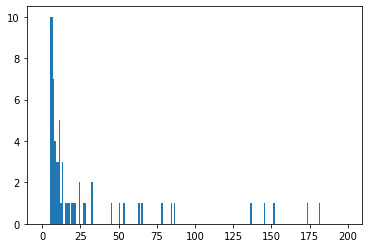

,CPT_CD
SECTIONHEADER,
Anesthesia,1
Evaluation and management,19
Medicine,9
Radiology,2
Surgery,49


In [317]:
# How many unique CPT codes are there in each group? #####
print(len(np.unique(filtered_df['CPT_CD'])))
print(len(np.unique(note_cpt['CPT_CD'])))

##### When not stratifying
# 1,991 total codes and 121 codes where == 1 CPT codes
# 1,991 total codes and 133 codes where <= 2 CPT codes
# 1,991 total codes and 134 codes where <= 3 CPT codes

### When stratifying by section header
# 1984 total codes and 1610 codes where == 1 CPT codes
# Only 374 codes are lost compared to 1870 codes

# What is the distribution of CPT code counts?
print(note_cpt.groupby('HADM_ID')['CPT_CD'].count().describe())
plt.hist(filtered_df['CPT_CD'].value_counts(), bins=range(200))
plt.show()

# Length of the filtered data
len(filtered_df) # 131,592
len(note_cpt) # 223,690
#### Lost about 90K records due to filtering and 374 CPT codes

# What are the counts by the section headers?
filtered_df['SECTIONHEADER'].value_counts()

# Group by and count the number of CPT codes
x = filtered_df.groupby(['SECTIONHEADER', 'CPT_CD'], as_index = False)['CPT_CD'].count()

# How many CPT codes are there by section header?
x.groupby('SECTIONHEADER').count()

# Clean the data

In [508]:
def clean_data(text_series):
    
    # Replace \n 
    text_series = text_series.str.replace('\\n',' ', regex=True)    

    # Remove dates and locations
    text_series = text_series.str.replace('\[\*\*(.*?)\*\*\]', ' ', regex=True)
    
    # Remove topics
    data = text_series.str.split('([A-Z\s]+:)')
    for row_num, value in enumerate(data):
        text_chunks = [x.strip().replace(':','').replace('\n', '') for x in value]
        for i, x in enumerate(text_chunks):
            if 'MEDICATION' in x or 'SOCIAL HISTORY' in x or 'FAMILY HISTORY' in x:
                text_chunks[i] = ' '
                try:
                    text_chunks[i + 1] = ' '
                except:
                    continue

        text_series.iloc[row_num] = ' '.join(text_chunks)
    
    # Replace punctuation
    text_series = text_series.str.replace('[' + string.punctuation + ']', ' ', regex=True)
    
    # Convert to lowercase 
    text_series = text_series.str.lower()
    
    # Remove all digits
    text_series = text_series.str.replace('\d',' ', regex=True)
    
    # Replace plurals, endings with ing, endings with ed, endings with ly
#     text_series = text_series.str.replace('s(?=\s)', ' ', regex=True)
#     text_series = text_series.str.replace('ing(?=\s)', ' ', regex=True)
#     text_series = text_series.str.replace('ed(?=\s)', ' ', regex=True)
#     text_series = text_series.str.replace('ly(?=\s)', ' ', regex=True)
    
    return text_series

# Update Text Column -----
filtered_df.loc[:, 'TEXT'] = clean_data(filtered_df['TEXT']).values

c:\users\amartins\onedrive - intermountain healthcare\python_pycharm_virt_env\.venv\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# Label Encode the Predictors

In [44]:
le = preprocessing.LabelEncoder()
filtered_df['CPT_CD'] = le.fit_transform(filtered_df['CPT_CD'])

# Check the Counts for Each Section

In [498]:
print(filtered_df['SECTIONHEADER'].value_counts())
filtered_df[filtered_df['SECTIONHEADER'] == 'Medicine']['CPT_CD'].value_counts()

Evaluation and management    13437
Medicine                     12086
Surgery                       1317
Name: SECTIONHEADER, dtype: int64


94003    7183
94002    4506
90935     272
99024     125
Name: CPT_CD, dtype: int64

# Split the Data

In [509]:
tt_dict = {} 

def split_stratify_df(df):
    
    for i in set(df['SECTIONHEADER']):
        df_x = df[df['SECTIONHEADER'] == i]['TEXT'].values
        df_y = df[df['SECTIONHEADER'] == i]['CPT_CD']
        tt_dict['X_train_' + i], tt_dict['X_test_' + i], tt_dict['y_train_' + i], tt_dict['y_test_' + i], \
        tt_dict['index_train_' + i], tt_dict['index_test_' + i] = \
        train_test_split(df_x, df_y, range(len(df_y)), test_size = .1, random_state = 42, shuffle=True)

split_stratify_df(filtered_df)

In [511]:
# Print sections
print(list(set(filtered_df['SECTIONHEADER'])))

# Select a section
section = list(set(filtered_df['SECTIONHEADER']))[4]

['Evaluation and management', 'Anesthesia', 'Radiology', 'Surgery', 'Medicine']


# Balance the data

In [512]:
def oversample_df(filtered_df, percentile):
    
    # Check counts
    df_cts = filtered_df['CPT_CD'].value_counts()
    record_ct = round(np.percentile(df_cts, percentile))
    print('New Balanced Record Count per CPT: {}'.format(record_ct))
    
    # Create a list of CPT values
    df = list(df_cts.index.values)

    # Resample
    minority_df = []
    for i in df:
        test_resampled = resample(filtered_df[filtered_df['CPT_CD'] == i], replace=True, n_samples=record_ct, random_state=123)
        minority_df.append(test_resampled)
    
    # Create final dataframe
    new_df = pd.concat(minority_df)
    new_df['CPT_CD'] = new_df['CPT_CD']
    
    return new_df

# Recombine the training dataset
x = pd.Series(tt_dict['X_train_' + section]).reset_index(drop=True)
y = pd.Series(tt_dict['y_train_' + section]).reset_index(drop=True)
training_df = pd.concat([x,y], axis=1, ignore_index=True)
training_df.columns = ['TEXT', 'CPT_CD']

# Run the function
training_balanced = oversample_df(training_df, 95)

New Balanced Record Count per CPT: 10104


In [513]:
# Split the training and test datasets again and reassign to the dictionary
tt_dict['X_train_' + section] = np.array(training_balanced['TEXT'].values)
tt_dict['y_train_' + section] = np.array(training_balanced['CPT_CD'].values)

# Check for Imbalance

In [467]:
np.unique(training_balanced['CPT_CD'].value_counts())

array([10104], dtype=int64)

# Tokenize the data

In [514]:
# Define stop words
my_stop_words = list(set(stopwords.words('english'))) \
                + ['admission', 'date', 'sex'] \
                + ['needed', 'every', 'seen', 'weeks', 'please', 'ml', 'unit', 'small', 'year', 'old', 'cm', 'non', 'mm', 'however']
                # Got the above from my top 100 most predictive words that I wanted to remove

def vectorize_df(train_test_dict, section):
    
    # Import TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words=my_stop_words)

    # Transform the training data
    tfidf_train = tfidf_vectorizer.fit_transform(train_test_dict['X_train_' + section])

    # Transform the test data
    tfidf_test = tfidf_vectorizer.transform(train_test_dict['X_test_' + section])
    
    # Add results to dictionary
    vectorized_words = {}
    vectorized_words['tfidf_train'] = tfidf_train
    vectorized_words['tfidf_test'] = tfidf_test
    
    return vectorized_words, tfidf_vectorizer

# Select a section
print('Selected section: ', section)

vectorized_words, tfidf_vectorizer = vectorize_df(tt_dict, section)                                                                    

Selected section:  Medicine


# Run Naive Bayes

In [515]:
def run_clf(vectorized_words, train_test_dict, section):

    # Use Naive Bayes model
    nb_classifier = MultinomialNB(alpha=.7)

    # Fit and check accuracy
    nb_classifier.fit(vectorized_words['tfidf_train'], train_test_dict['y_train_' + section])
    pred = nb_classifier.predict(vectorized_words['tfidf_test'])
    
    print(metrics.accuracy_score(train_test_dict['y_test_' + section], pred))
    
    return pred, nb_classifier
    
pred, nb_classifier = run_clf(vectorized_words, tt_dict, section)

0.504359197907585


# Evaluation

In [433]:
# Check accuracy
print(metrics.accuracy_score(tt_dict['y_test_' + section], pred))


# Final Results #####
# E/M: 0.21846553966189858 - 10 codes
# Radiology: .825 - 2 codes
# Surgery: 0.4258474576271186 - 10 codes
# Medicine: 0.504359197907585 - 8 codes

"""
Testing CPT per HADM
-----------------------------------------
Test size: .1
Random Number: 42
# of records per CPT: 5
Max duplicate CPTs per HADM allowed: 0
Category/Categories: Discharge Summary
Section Header: E/M

# of CPTs per HADM: 3
Accuracy: 0.24383561643835616

# of CPTs per HADM: 5
Accuracy: 0.22121896162528218

# of CPTs per HADM: 10
Accuracy: 0.2673684210526316

Results: Accuracy seems to increase with more, presumably due to more records
-----------------------------------------

#####

Testing CPT counts per section per HADM
-----------------------------------------
Test size: .1
Random Number: 42
# of records per CPT: 5
# of CPTs per HADM: 10
Category/Categories: Discharge Summary
Section Header: E/M
# of CPTs per section: 10

Max CPTs count per section per HADM allowed: 1
Record Ct: 15376
Balanced Ct: 3321
Accuracy: 0.21846553966189858

Max CPTs count per section per HADM allowed: 2
Record Ct: 15376
Balanced Ct: 3321
Accuracy: 0.21846553966189858

Max CPTs count per section per HADM allowed: 5
Record Ct: 83534

Accuracy: 0.1390950442901604


Results: 
-----------------------------------------

#####

Testing # Notes per CPT
-----------------------------------------
Test size: .1
Random Number: 42
# of records per CPT: 5
# of CPTs per HADM: 10
Category/Categories: Discharge Summary
Section Header: E/M
Max CPTs count per section per HADM allowed: 1


# of CPTs per section: 5
Record Ct: 15376
Balanced Ct: 3321
Accuracy: 0.21846553966189858

# of CPTs per section: 1000
Record Ct: 12355
Balanced Ct: 3761
Accuracy: 0.2726537216828479

Results: More notes looks like it is more predictive
-----------------------------------------

"""



0.2726537216828479


'\nTesting CPT per HADM\n-----------------------------------------\nTest size: .1\nRandom Number: 42\n# of records per CPT: 5\nMax duplicate CPTs per HADM allowed: 0\nCategory/Categories: Discharge Summary\nSection Header: E/M\n\n# of CPTs per HADM: 3\nAccuracy: 0.24383561643835616\n\n# of CPTs per HADM: 5\nAccuracy: 0.22121896162528218\n\n# of CPTs per HADM: 10\nAccuracy: 0.2673684210526316\n\nResults: Accuracy seems to increase with more, presumably due to more records\n-----------------------------------------\n\n#####\n\nTesting CPT counts per section per HADM\n-----------------------------------------\nTest size: .1\nRandom Number: 42\n# of records per CPT: 5\n# of CPTs per HADM: 10\nCategory/Categories: Discharge Summary\nSection Header: E/M\n# of CPTs per section: 10\n\nMax CPTs count per section per HADM allowed: 1\nRecord Ct: 15376\nBalanced Ct: 3321\nAccuracy: 0.21846553966189858\n\nMax CPTs count per section per HADM allowed: 2\nRecord Ct: 15376\nBalanced Ct: 3321\nAccuracy:

# Classification Report

In [516]:
# Create classification report taken from here: https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
print('Test')
class_labels = nb_classifier.classes_
print(classification_report(tt_dict['y_test_' + section], pred))

print('Training')
pred_x = nb_classifier.predict(vectorized_words['tfidf_train'])
print(classification_report(tt_dict['y_train_' + section], pred_x))

# Counts by number of CPT values in test
# print(tt_dict['y_test_' + section].value_counts())

Test
              precision    recall  f1-score   support

       90801       0.11      0.45      0.18        31
       90935       0.26      0.69      0.38        89
       90937       0.00      0.00      0.00        14
       90945       0.07      0.24      0.11        17
       93503       0.03      0.43      0.05         7
       94002       0.52      0.51      0.51       788
       94003       0.72      0.50      0.59      1330
       99024       0.21      1.00      0.34        18

    accuracy                           0.50      2294
   macro avg       0.24      0.48      0.27      2294
weighted avg       0.61      0.50      0.54      2294

Training
              precision    recall  f1-score   support

       90801       0.90      0.92      0.91     10104
       90935       0.81      0.77      0.79     10104
       90937       0.91      0.99      0.95     10104
       90945       0.94      0.98      0.96     10104
       93503       0.91      0.94      0.92     10104
       940

# Make Predictions

In [315]:
def predict_cpt(text):
    input_text_clean = clean_data(pd.Series(text))
    tfidf_input_test = tfidf_vectorizer.transform(input_text_clean)
    print(nb_classifier.predict(tfidf_input_test)[0], str(round(max(nb_classifier.predict_proba(tfidf_input_test)[0]) * 100,2)) + '%')
    print(nb_classifier.predict_proba(tfidf_input_test)[0])
          
text_cpt = 'valvuloplasty mitral valve or subvalvular structures to correct mitral stenosis or subvalvular fibrosis with the patient on a heart–lung machine to reroute the circulation of blood and bypass the heart and lungs. The provider may insert a band or ring around the anulus to correct mitral insufficiency if the valve is leaking due to annular dilatation.'
predict_cpt(text_cpt)

33427 22.77%
[0.04742518 0.04763856 0.04704341 0.14166082 0.22769757 0.21479557
 0.10340254 0.07079546 0.06247875 0.03706214]
